# Initializing pySpark
We use the package [findspark](https://pypi.org/project/findspark/) in order to init the `SparkContext`. Since we're working with *[DataFrames](https://spark.apache.org/docs/3.2.0/api/python/reference/api/pyspark.sql.DataFrame.html#pyspark.sql.DataFrame)* we need to init a `SparkSession` too. The pySpark version is **3.2.0**.<br>
The MovieLens dataset can be found at the following [link](https://files.grouplens.org/datasets/movielens/ml-1m.zip).

In [1]:
# Used to suppress the 'Deprecation Warnings' for Seaborn distplot
# No pySpark warning is suppressed by this option 
import warnings
warnings.filterwarnings("ignore")

import findspark

findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

conf = SparkConf().setAppName("MovieLens Dataset").setMaster("local")
sc = SparkContext(conf=conf)
ss = SparkSession(sc)

21/12/09 12:05:26 WARN Utils: Your hostname, equilibria.local resolves to a loopback address: 127.0.0.1; using 157.27.128.121 instead (on interface en0)
21/12/09 12:05:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/12/09 12:05:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Loading the Dataset
## Importing .dat files
The first step is to load the dataset, we can do this using the Pandas `read_table()` [function](https://pandas.pydata.org/docs/reference/api/pandas.read_table.html).<br>
Doing so we obtain 2 DataFrames:
* **Movies**: 3883 x 3
* **Ratings**: 1000209 x 4

In [2]:
import pandas as pd

movies_pd_dataset = pd.read_table("data/movies.dat", 
                                  delimiter="::", 
                                  names=["MovieID", "Title", "Genres"], 
                                  engine="python")

ratings_pd_dataset = pd.read_table("data/ratings.dat", 
                                   delimiter="::", 
                                   names=["UserID", "MovieID", "Rating", "Timestamp"], 
                                   engine="python")

In order to simplify data analisys, it's preferable to turn the "*Timestamp*" column into a more flexible date type.<br>
To do so we use the Pandas `to_datetime()` static [method](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html), followed by a *drop* of the "time part" of the data. The resulting date is formatted in the following way: `yyyy-mm-dd`. 

In [3]:
ratings_pd_dataset["Timestamp"] = pd.to_datetime(
    ratings_pd_dataset["Timestamp"],
    unit="s"
).dt.date

## Creating a Schema
In order to simplify the access to our DataFrames we provide a custom [schema](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.types.StructType.html) to the `createDataFrame()` [function](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.SparkSession.createDataFrame.html#pyspark.sql.SparkSession.createDataFrame).<br>
As a result of this operation is possible to specify which data [type](https://spark.apache.org/docs/latest/api/python/search.html?q=PySpark.sql.types#) we want to use for each column, reducing the space used by our DataFrames.

In [4]:
from pyspark.sql.types import StructType, StructField, StringType, ShortType, DateType

movies_schema = StructType([
    StructField("MovieID", ShortType(), False),
    StructField("Title", StringType(), False),
    StructField("Genres", StringType(), False)
])

ratings_schema = StructType([
    StructField("UserID", ShortType(), False),
    StructField("MovieID", ShortType(), False),
    StructField("Rating", ShortType(), False),
    StructField("Date", DateType(), False)
])

movies_dataset = ss.createDataFrame(movies_pd_dataset, schema=movies_schema)
ratings_dataset = ss.createDataFrame(ratings_pd_dataset, schema=ratings_schema)

# Exploratory Analysis

## Query 1
Find the *number of ratings* and *distribution* for each movie

21/12/09 12:06:50 WARN TaskSetManager: Stage 87 contains a task of very large size (13603 KiB). The maximum recommended task size is 1000 KiB.


+-----------------+
|Number of Ratings|
+-----------------+
|             2077|
|              701|
|              478|
|              170|
|              296|
|              940|
|              458|
|               68|
|              102|
|              888|
|             1033|
|              160|
|               99|
|              153|
|              146|
|              682|
|              835|
|              157|
|              389|
|              160|
+-----------------+
only showing top 20 rows



21/12/09 12:06:50 WARN TaskSetManager: Stage 90 contains a task of very large size (13603 KiB). The maximum recommended task size is 1000 KiB.


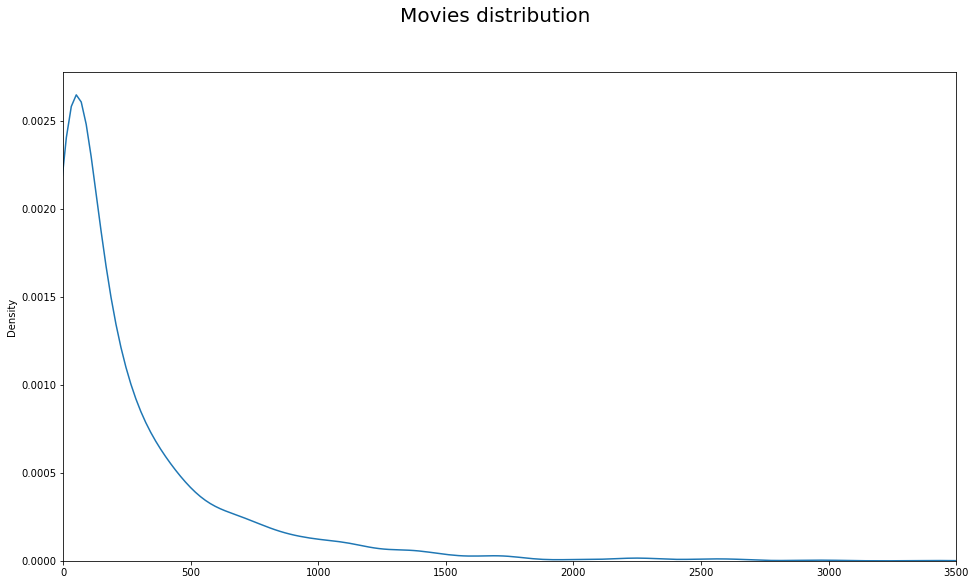

In [14]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
import seaborn as sns

# Number of ratings
ratings_dataset.groupBy("MovieID").count()\
               .orderBy("MovieID")\
               .select(col("count").alias("Number of Ratings")).show()

# Distribution plot
plt.figure(figsize=(16,9))

sns.distplot(
    ratings_dataset.groupBy("MovieID").count()
                   .orderBy("MovieID")\
                   .select("count")\
                   .toPandas(),
    hist=False,
    kde=True
)

plt.xlim([0, 3500])
plt.suptitle("Movies distribution", fontsize=20)

plt.show()

## Query 2
Find the *number of ratings* and *distribution* for each user

21/12/09 12:07:17 WARN TaskSetManager: Stage 98 contains a task of very large size (13603 KiB). The maximum recommended task size is 1000 KiB.


+-----------------+
|Number of Ratings|
+-----------------+
|               53|
|              129|
|               51|
|               21|
|              198|
|               71|
|               31|
|              139|
|              106|
|              401|
|              137|
|               23|
|              108|
|               25|
|              201|
|               35|
|              211|
|              305|
|              255|
|               24|
+-----------------+
only showing top 20 rows



21/12/09 12:07:17 WARN TaskSetManager: Stage 101 contains a task of very large size (13603 KiB). The maximum recommended task size is 1000 KiB.


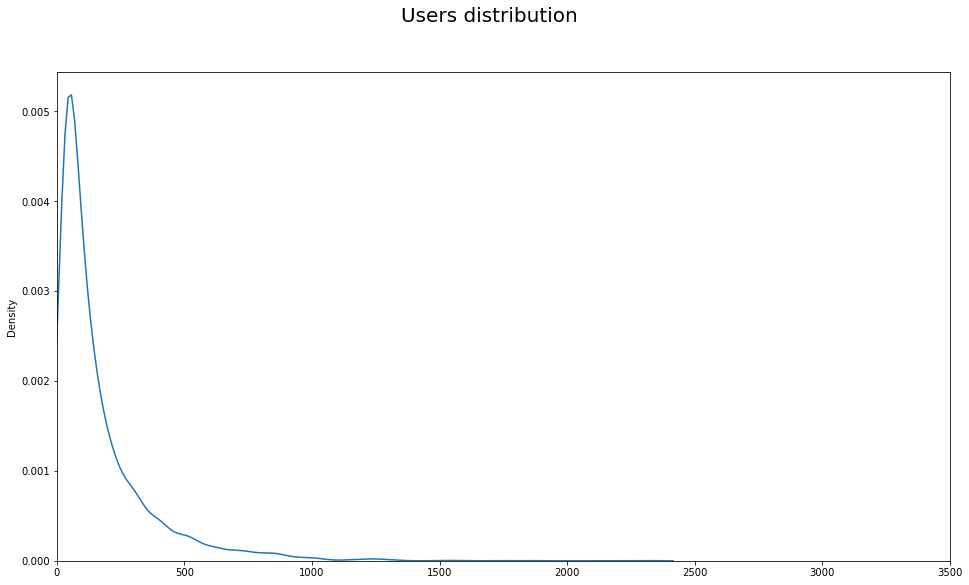

In [15]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
import seaborn as sns

# Number of ratings
ratings_dataset.groupBy("UserID").count()\
               .orderBy("UserID")\
               .select(col("count").alias("Number of Ratings")).show()

# Distribution plot
plt.figure(figsize=(16,9))

sns.distplot(
    ratings_dataset.groupBy("UserID").count()
                   .orderBy("UserID")\
                   .select("count")\
                   .toPandas(),
    hist=False,
    kde=True
)

plt.xlim([0, 3500])
plt.suptitle("Users distribution", fontsize=20)

plt.show()

## Query 3
Find the *average score* recieved by each movie

In [7]:
from pyspark.sql.functions import col, format_number, mean

ratings_dataset.groupBy("MovieID").agg(mean(col("Rating")))\
               .orderBy("MovieID")\
               .select(
                   "MovieID", 
                   format_number("avg(Rating)", 4).alias("Average")
               )\
               .show()

21/12/09 12:05:43 WARN TaskSetManager: Stage 22 contains a task of very large size (13603 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------+
|MovieID|Average|
+-------+-------+
|      1| 4.1468|
|      2| 3.2011|
|      3| 3.0167|
|      4| 2.7294|
|      5| 3.0068|
|      6| 3.8787|
|      7| 3.4105|
|      8| 3.0147|
|      9| 2.6569|
|     10| 3.5405|
|     11| 3.7938|
|     12| 2.3625|
|     13| 3.2626|
|     14| 3.5425|
|     15| 2.4589|
|     16| 3.7933|
|     17| 4.0275|
|     18| 3.3376|
|     19| 2.4807|
|     20| 2.5375|
+-------+-------+
only showing top 20 rows



## Query 4
Find the *average score* given by each user 

In [8]:
from pyspark.sql.functions import col, format_number, mean

ratings_dataset.groupBy("UserID").agg(mean(col("Rating")))\
               .orderBy("UserID")\
               .select(
                   "UserID", 
                   format_number("avg(Rating)", 4).alias("Average")
               ).show()

21/12/09 12:05:43 WARN TaskSetManager: Stage 25 contains a task of very large size (13603 KiB). The maximum recommended task size is 1000 KiB.


+------+-------+
|UserID|Average|
+------+-------+
|     1| 4.1887|
|     2| 3.7132|
|     3| 3.9020|
|     4| 4.1905|
|     5| 3.1465|
|     6| 3.9014|
|     7| 4.3226|
|     8| 3.8849|
|     9| 3.7358|
|    10| 4.1147|
|    11| 3.2774|
|    12| 3.8261|
|    13| 3.3889|
|    14| 3.3200|
|    15| 3.3234|
|    16| 3.0286|
|    17| 4.0758|
|    18| 3.6492|
|    19| 3.5725|
|    20| 4.0833|
+------+-------+
only showing top 20 rows



## Query 5
Top **K** movies with at least **R** ratings

In [9]:
from pyspark.sql.functions import col

# Number of movies to show in the result
K = 10

# Minimum number of ratings each movie should have
R = 20

movies_dataset.join(ratings_dataset, "MovieID").groupBy("MovieID").count()\
              .orderBy("MovieID").withColumnRenamed("count", "Number of Ratings")\
              .filter(col("Number of Ratings") >= R).limit(K).show()

21/12/09 12:05:44 WARN TaskSetManager: Stage 29 contains a task of very large size (13603 KiB). The maximum recommended task size is 1000 KiB.


+-------+-----------------+
|MovieID|Number of Ratings|
+-------+-----------------+
|      1|             2077|
|      2|              701|
|      3|              478|
|      4|              170|
|      5|              296|
|      6|              940|
|      7|              458|
|      8|               68|
|      9|              102|
|     10|              888|
+-------+-----------------+



# Queries

## Query 1
Find if there is a correlation between the *standard deviation* of the **ratings** a movie has received, and the *number of ratings*.<br><br>
As shown in the plot, reducing the number of movies slightly alters the density of the data, but not in the way we expect. That's beacause instead of being distributed "*normally*" (following a **Normal Distribution**) as proven by the *Skewness* results at the bottom of the plot, the data follows a **Paretian Distribution** (as we can se from the side-to-side comparison below the distribution plot).

21/12/09 12:05:45 WARN TaskSetManager: Stage 35 contains a task of very large size (13603 KiB). The maximum recommended task size is 1000 KiB.
21/12/09 12:05:45 WARN TaskSetManager: Stage 41 contains a task of very large size (13603 KiB). The maximum recommended task size is 1000 KiB.
21/12/09 12:05:46 WARN TaskSetManager: Stage 47 contains a task of very large size (13603 KiB). The maximum recommended task size is 1000 KiB.
21/12/09 12:05:47 WARN TaskSetManager: Stage 53 contains a task of very large size (13603 KiB). The maximum recommended task size is 1000 KiB.


<Figure size 432x288 with 0 Axes>

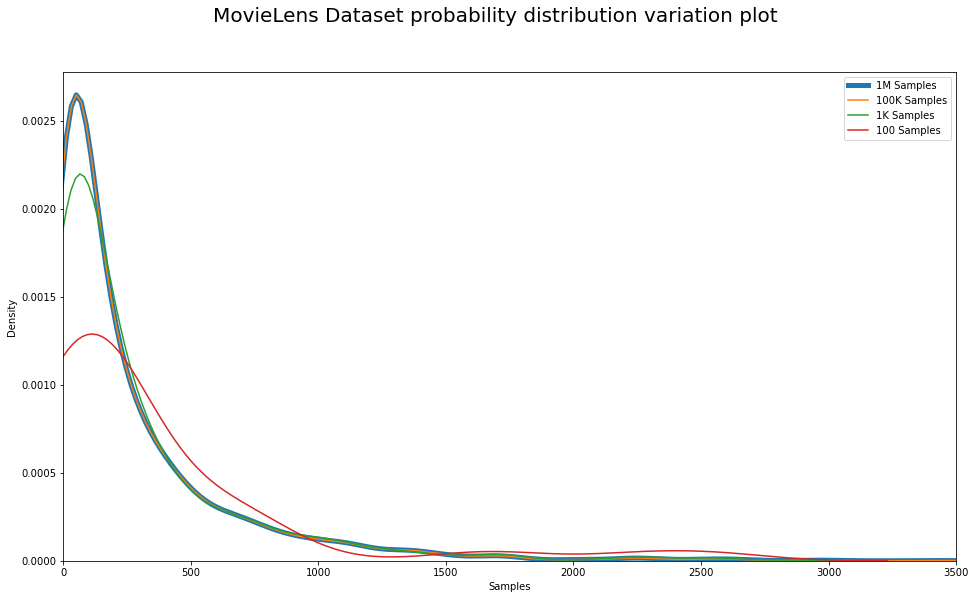

Skewness 1M samples: [0.]
Skewness 100K samples: [0.]
Skewness 1K samples: [8.78198508e-96]
Skewness 100 samples: [1.04995273e-12]


In [10]:
import matplotlib.pyplot as plt
from scipy.stats import skew, skewtest
import seaborn as sns

one_M_samples = movies_dataset.join(ratings_dataset, "MovieID")\
                              .groupBy("MovieID").count()\
                              .select("count")\
                              .toPandas()

hundred_K_samples = movies_dataset.join(ratings_dataset, "MovieID")\
                                  .groupBy("MovieID").count()\
                                  .select("count")\
                                  .limit(100000)\
                                  .toPandas()

one_K_samples = movies_dataset.join(ratings_dataset, "MovieID")\
                              .groupBy("MovieID").count()\
                              .select("count")\
                              .limit(1000)\
                              .toPandas()

hundred_samples = movies_dataset.join(ratings_dataset, "MovieID")\
                                .groupBy("MovieID").count()\
                                .select("count")\
                                .limit(100)\
                                .toPandas()

# Plotting section
plt.clf()

fig = plt.figure(figsize=(16, 9))

fig.suptitle(
    "MovieLens Dataset probability distribution variation plot", 
    fontsize=20
)

sns.distplot(
    one_M_samples,
    hist=False,
    kde=True,
    kde_kws={"linewidth": 5},
    label="1M Samples"
)

sns.distplot(
    hundred_K_samples,
    hist=False,
    kde=True,
    label="100K Samples"
)

sns.distplot(
    one_K_samples,
    hist=False,
    kde=True,
    label="1K Samples"
)

sns.distplot(
    hundred_samples,
    hist=False,
    kde=True,
    label="100 Samples"
)

plt.legend()
plt.xlabel("Samples")
plt.xlim([0, 3500])

plt.show()

print(f"Skewness 1M samples: {skewtest(one_M_samples)[1]}")
print(f"Skewness 100K samples: {skewtest(hundred_K_samples)[1]}")
print(f"Skewness 1K samples: {skewtest(one_K_samples)[1]}")
print(f"Skewness 100 samples: {skewtest(hundred_samples)[1]}")

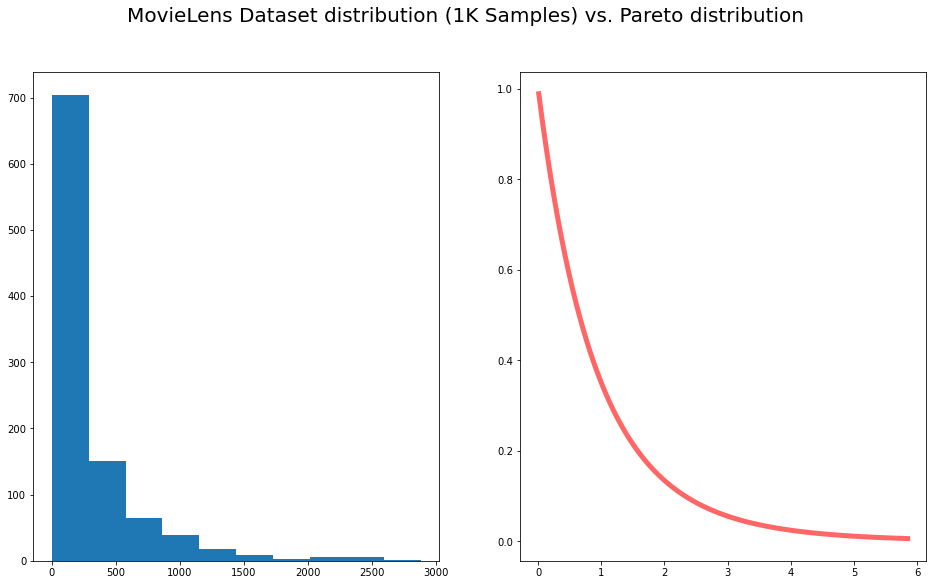

In [11]:
import numpy as np
from scipy.stats import genpareto

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))

fig.suptitle(
    "MovieLens Dataset distribution (1K Samples) vs. Pareto distribution",
    fontsize=20
)

ax1.hist(one_K_samples)

c = 0.1

mean, var, skew, kurt = genpareto.stats(c, moments='mvsk')
x = np.linspace(genpareto.ppf(0.01, c), genpareto.ppf(0.99, c), 100)

ax2.plot(x, genpareto.pdf(x, c), 'r-', lw=5, alpha=0.6, label='genpareto pdf')

plt.show()

## Query 2
Find the *evolution over time* (with a granularity of **N** months) of the *number of ratings* and the *average rating*: do high rated movies maintain their ratings? Are low rated movies “abandoned” after a while?<br><br>
The basic assumption in this query is that `N=4`.<br>
In the first plot we can se that, after *a year* of ratings, the movies labelled as **High Rated** (using the 3 star rating as threshold) get double the ratings if compared with the ones labelled as **Low Rated**. We can assume the existence of a downward trend in the number of ratings for "*unappreciated*" movies.<br><br>
In the second plot we can visualize the trend mentioned above. Even if low rated movies tend to be abandoned after a year, high rated ones follow a similar trend. The intresting aspect that confirms the assumption made analyzing the *barplot*, is that the majority of movies with a number of ratings in the 40 to 100 range are **High Rated** movies, with few exception for **Low Rated** ones.<br>
Said so, we can safely state that **High Rated** movies have the tendency to be reviewed after a year, even if the rating frequency is lower. **Low Rated** movies, on the other hand, tend to be abandoned after a while.

21/12/09 12:12:21 WARN TaskSetManager: Stage 232 contains a task of very large size (13603 KiB). The maximum recommended task size is 1000 KiB.
21/12/09 12:12:24 WARN TaskSetManager: Stage 233 contains a task of very large size (13603 KiB). The maximum recommended task size is 1000 KiB.
21/12/09 12:12:27 WARN TaskSetManager: Stage 234 contains a task of very large size (13603 KiB). The maximum recommended task size is 1000 KiB.
21/12/09 12:12:31 WARN TaskSetManager: Stage 235 contains a task of very large size (13603 KiB). The maximum recommended task size is 1000 KiB.
21/12/09 12:12:34 WARN TaskSetManager: Stage 236 contains a task of very large size (13603 KiB). The maximum recommended task size is 1000 KiB.
21/12/09 12:12:37 WARN TaskSetManager: Stage 250 contains a task of very large size (13603 KiB). The maximum recommended task size is 1000 KiB.
21/12/09 12:12:41 WARN TaskSetManager: Stage 251 contains a task of very large size (13603 KiB). The maximum recommended task size is 10

Number of High Rated Movies (threshold=3): 2080
Number of Low Rated Movies (threshold=3): 627


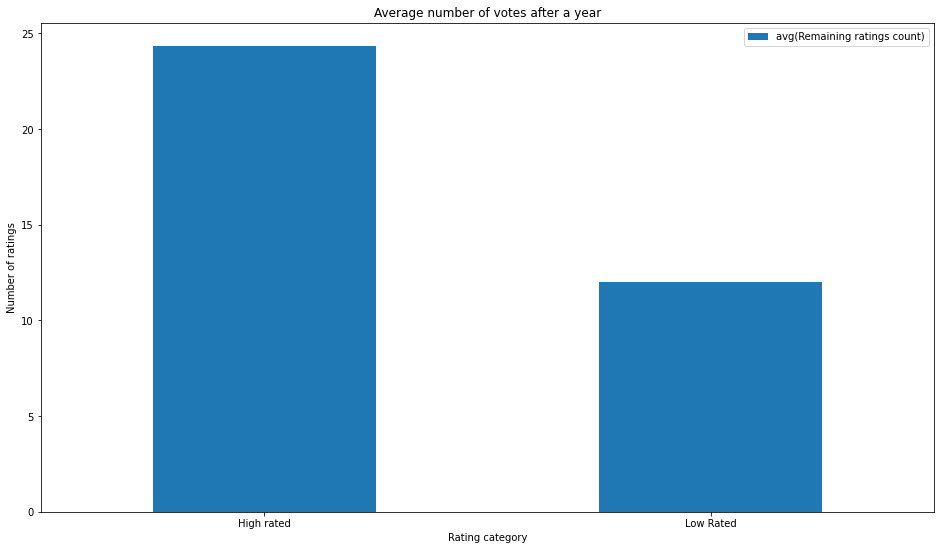

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import col, lit, mean, trunc, udf
from pyspark.sql.types import StringType

"""
Assumption: N = 4 (using quartiles)
"""

@udf(returnType=StringType())
def quartiles(date):
    if date.year == 2000:
        if 4 <= date.month <= 6:
            return "Q1"
        
        if 7 <= date.month <= 9:
            return "Q2"

        if 10 <= date.month <= 12:
            return "Q3"

    if date.year == 2001:
        if 1 <= date.month <= 3:
            return "Q4"

    return "Remaining"


ratings_quartiles = ratings_dataset.select(
                                       "UserID",
                                       "MovieID",
                                       "Rating",
                                       trunc(
                                            col("Date"), 
                                            "Month"
                                       ).alias("Year-Month")
                                   ).withColumn(
                                       "Quartile",
                                       quartiles("Year-Month")
                                   ).drop("UserID")

q1_avg_ratings = ratings_quartiles.filter(col("Quartile") == "Q1")\
                                  .groupBy("MovieID")\
                                  .agg(mean("Rating"))\
                                  .withColumnRenamed(
                                      "avg(Rating)",
                                      "Q1"
                                  )

q2_avg_ratings = ratings_quartiles.filter(col("Quartile") == "Q2")\
                                  .groupBy("MovieID")\
                                  .agg(mean("Rating"))\
                                  .withColumnRenamed(
                                      "avg(Rating)",
                                      "Q2"
                                  )

q3_avg_ratings = ratings_quartiles.filter(col("Quartile") == "Q3")\
                                  .groupBy("MovieID")\
                                  .agg(mean("Rating"))\
                                  .withColumnRenamed(
                                      "avg(Rating)",
                                      "Q3"
                                  )

q4_avg_ratings = ratings_quartiles.filter(col("Quartile") == "Q4")\
                                  .groupBy("MovieID")\
                                  .agg(mean("Rating"))\
                                  .withColumnRenamed(
                                      "avg(Rating)",
                                      "Q4"
                                  )

remaining_ratings = ratings_quartiles.filter(col("Quartile") == "Remaining")\
                                     .groupBy("MovieID")\
                                     .count()\
                                     .withColumnRenamed(
                                         "count",
                                         "Remaining ratings count"
                                     )

joined_df = q1_avg_ratings.join(q2_avg_ratings, "MovieID")\
                          .join(q3_avg_ratings, "MovieID")\
                          .join(q4_avg_ratings, "MovieID")\
                          .join(remaining_ratings, "MovieID")

# The average rating of the dataset is actually 3.6
threshold = 3


@udf(returnType=StringType())
def frequency(q1, q2, q3, q4):
    lrated = 0
    hrated = 0

    if q1 >= threshold:
        hrated += 1
    else:
        lrated += 1

    if q2 >= threshold:
        hrated += 1
    else:
        lrated += 1

    if q3 >= threshold:
        hrated += 1
    else:
        lrated += 1

    if q4 >= threshold:
        hrated += 1
    else:
        lrated += 1

    if hrated >= lrated:
        return "High rated"
    
    return "Low Rated"


result_df = joined_df.withColumn(
                         "Rating category",
                         frequency(col("Q1"), col("Q2"), col("Q3"), col("Q4"))
                     ).orderBy("MovieID")

category_count =result_df.groupBy("Rating category").count().collect()

category_avg = result_df.groupBy("Rating category")\
                        .agg(mean("Remaining ratings count"))\
                        .toPandas()

# Plotting section
category_avg.plot.bar(
    x="Rating category", 
    y="avg(Remaining ratings count)", 
    rot=0, 
    figsize=(16, 9),
    ylabel="Number of ratings",
    title="Average number of votes after a year",
)

print(f"Number of High Rated Movies (threshold=3): {category_count[0]['count']}")
print(f"Number of Low Rated Movies (threshold=3): {category_count[1]['count']}")

21/12/09 12:13:37 WARN TaskSetManager: Stage 268 contains a task of very large size (13603 KiB). The maximum recommended task size is 1000 KiB.
21/12/09 12:13:40 WARN TaskSetManager: Stage 269 contains a task of very large size (13603 KiB). The maximum recommended task size is 1000 KiB.


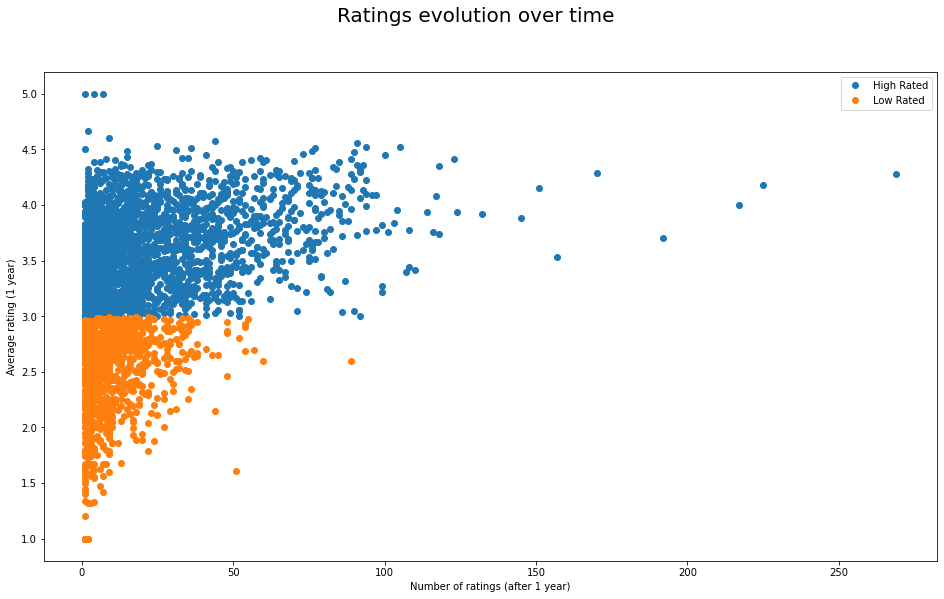

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import mean, udf
from pyspark.sql.types import StringType

@udf(returnType=StringType())
def getYear(date):
    if (date.year == 2000) or date.year == 2001 and (1 <= date.month <= 3):
        return "Significant"
    
    return "Remaining"


partitioned_df = ratings_dataset.select(
                                       "UserID",
                                       "MovieID",
                                       "Rating",
                                       trunc(
                                            col("Date"), 
                                            "Month"
                                       ).alias("Year-Month")
                                   ).withColumn(
                                       "Type",
                                       getYear("Year-Month")
                                   ).drop("UserID")

significant_df = partitioned_df.filter(col("Type") == "Significant")\
                              .groupBy("MovieID")\
                              .agg(mean("Rating"))

remaining_df = partitioned_df.filter(col("Type") == "Remaining")\
                              .groupBy("MovieID")\
                              .count()

# The average rating of the dataset is actually 3.6
threshold = 3


@udf(returnType=StringType())
def category(avg):
    if avg >= threshold:
        return "High Rated"

    return "Low Rated"


scatter_df = significant_df.join(remaining_df, "MovieID")\
                          .withColumn(
                              "Rating category",
                              category("avg(Rating)")
                          )

# Plotting section
groups_no_pca = scatter_df.toPandas().groupby("Rating category")

plt.figure(figsize=(16, 9))

for name, group in groups_no_pca:
    plt.plot(
        group["count"],
        group["avg(Rating)"],
        marker="o",
        linestyle="",
        label=name
    )

plt.xlabel("Number of ratings (after 1 year)")
plt.ylabel("Average rating (1 year)")
plt.suptitle("Ratings evolution over time", fontsize=20)
plt.legend()

plt.show()

## Query 4
Is it possible to identify *groups of similar movies* based on the ratings they received from the users? For instance, if movies `m1` and `m2` have both obtained 5 stars from users `u1` and `u2`, they may be considered similar.<br><br>

Let's start the process by rearranging the data, we *drop* the columns that aren't usefull and *aggregate* the **MovieID** with the **Rating**, in order to obtain a *Pandas DataFrame* formatted like this:
```
UserID [MovieID, Rating]
```
After this process we can iterate over the grouped data (by `UserID`), doing so we produce a *Pandas DataFrame* having each `Rating r` represented as `r[UserID][MovieID]`.<br>
In the end, our DataFrame has some `NaN` gaps, because we can't expect to have a *User* who rated every *Movie* in the dataset. We fill those `NaN` gaps with the *mean*.

In [22]:
import pandas as pd
from pyspark.sql.functions import col, udf
from pyspark.sql.types import ArrayType, IntegerType

@udf(returnType=ArrayType(IntegerType()))
def aggregate(user, rating):
    return (int(user), int(rating))


grouped_ratings = ratings_dataset.join(movies_dataset, "MovieID")\
                                 .drop("Date", "Title", "Genres")\
                                 .withColumn(
                                     "Movie-Rating",
                                     aggregate(col("MovieID"), col("Rating"))
                                 ).drop("MovieID", "Rating")\
                                 .orderBy("UserID").toPandas()

data = {}

i = 1
for ratings in grouped_ratings.groupby("UserID")["Movie-Rating"].apply(tuple):
    data.update({i:{}})

    for rating in ratings:
        movie = rating[0]
        data[i].update({movie:rating[1]})

    i += 1

ratings = pd.DataFrame(data)
ratings.fillna(ratings.mean(), inplace=True)

21/12/09 12:13:47 WARN TaskSetManager: Stage 274 contains a task of very large size (13603 KiB). The maximum recommended task size is 1000 KiB.


Now we apply our **clustering algorithm**, I choose to use *KMeans*, since we saw it during the last lab. class and it's the first one which came up while searching in the pySpark [documentation](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.clustering.KMeans.html)

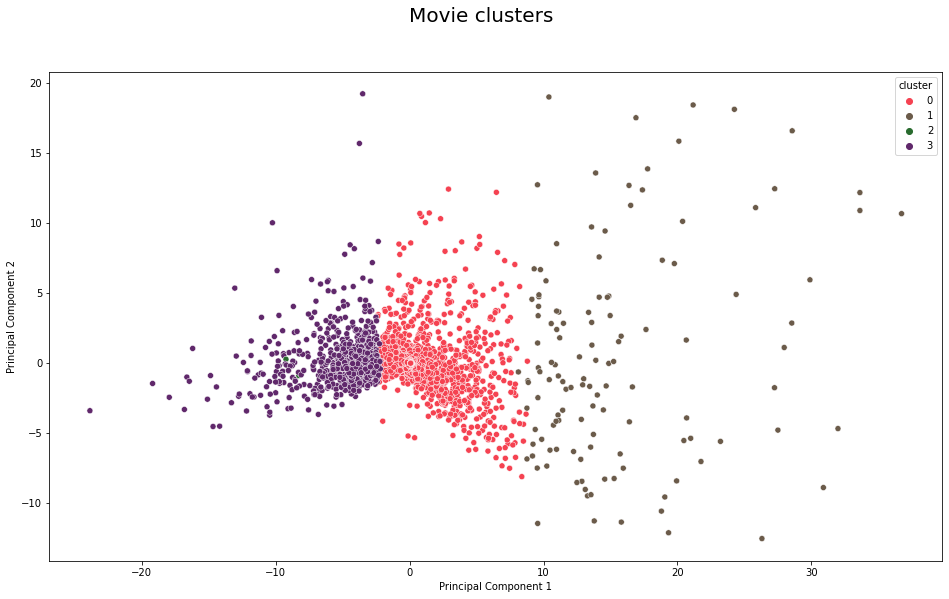

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

kmeans = KMeans(4)

clusters = kmeans.fit_predict(ratings[ratings.columns.tolist()])
ratings["cluster"] = clusters

pca = PCA(n_components=2)

principal_componets = pca.fit_transform(ratings)

pcc = pd.DataFrame(
    data=principal_componets,
    columns=["PC1", "PC2"],
    index=ratings.index.tolist()
)

pcc["cluster"] = ratings["cluster"]

plt.figure(figsize=(16, 9))

palette = ["#f54251", "#6b5b4a", "#286b2e", "#60286b"]
sns.scatterplot(
    data=pcc,
    x="PC1",
    y="PC2",
    hue="cluster",
    palette=palette
)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.suptitle("Movie clusters", fontsize=20)

plt.show()